In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mapply

from tqdm.notebook import tqdm
from pathlib import Path

tqdm.pandas()
mapply.init(n_workers=-1)

In [2]:
train_data = pd.read_csv(Path('data') / 'train.csv')
train_data['date'] = train_data['date'].mapply(pd.to_datetime)
train_data.set_index('date', inplace=True)
train_data.index = pd.DatetimeIndex(train_data.index).to_period('1D')
train_data

  0%|                                   | 0/40 [00:00<?, ?it/s]

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


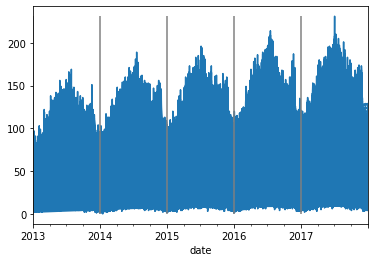

In [3]:
years = train_data.index.year.unique()
max_sales = train_data.sales.max()
ax = train_data['sales'].plot()
for year in years:
    ax.vlines(pd.to_datetime(str(year) + '-01-01'), ymin=0, ymax=max_sales, color='gray')
plt.show()

### series looks **trend-stationary** and **highly seasonal**

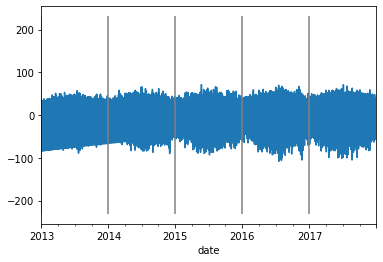

In [4]:
# try removing trend using first differences
ax = train_data['sales'].diff(periods=1).plot()
for year in years:
    ax.vlines(pd.to_datetime(str(year) + '-01-01'), ymin=-max_sales, ymax=max_sales, color='gray')
plt.show()
# seems to work

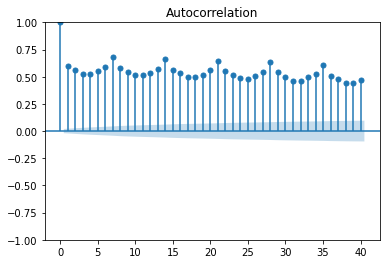

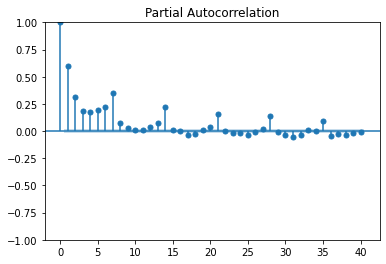

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plt.title('acf')
acf = plot_acf(train_data['sales'][:10000])
# plt.title('pacf')
pacf = plot_pacf(train_data['sales'][:10000], method='ywm')
# plt.title('pacf first diffs')
# pacf_diffs = plot_pacf(train_data['sales'].diff(periods=1), method='ywm')
plt.show()

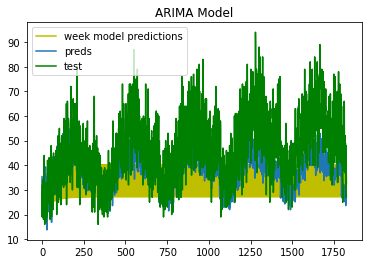

MSE (yearly model): 218.14757723068948
MSE (weekly model): 374.91768367971343


In [296]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error 


def train_test_simple_split(data: pd.DataFrame, test_size: int):
    return data[:-test_size], data[-test_size:]

test_size = 365 * 5
data_limit = 365*10
# data = train_data[train_data['store'] == 2]
data = train_data[train_data['item'] == 3]
data = data[:data_limit]
data = data['sales'].values
train, test = train_test_simple_split(data, test_size=test_size)


year_model = AutoReg(train, lags=120, seasonal=True, period=365)
year_model_fit = year_model.fit()
year_predictions = year_model_fit.predict(start=len(train), end=len(train)+len(test)-1)

week_model = AutoReg(train, lags=10, seasonal=True, period=7)
week_model_fit = week_model.fit()
week_predictions = week_model_fit.predict(start=len(train), end=len(train)+len(test)-1)

plt.title('ARIMA Model')
plt.plot(week_predictions, label='week model predictions', color='y')
plt.plot(year_predictions, label='preds')
plt.plot(test, label='test', color='g')
plt.legend()
plt.show()
print('MSE (yearly model):', mean_squared_error(year_predictions, test))
print('MSE (weekly model):', mean_squared_error(week_predictions, test))
# up until 5 weeks weekly model performs better than yearly model
# after that yearly model starts outperforming

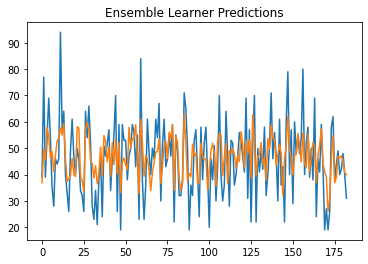

MSE Ensemble: 114.60687421240465


In [283]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

ensemble_model_X = pd.DataFrame()
ensemble_model_X['weekly_prediction'] = week_predictions
ensemble_model_X['yearly_prediction'] = year_predictions

X_train, X_test, y_train, y_test = train_test_split(ensemble_model_X, test, test_size=0.1)
ensembel = LinearRegression()
ensembel.fit(X_train, y_train)
ensembel_predictions = ensembel.predict(X_test)
plt.title('Ensemble Learner Predictions')
plt.plot(y_test, label='sales')
plt.plot(ensembel_predictions, label='ensemble predictions')
plt.show()
print(f'MSE Ensemble: {mean_squared_error(ensembel_predictions, y_test)}')

In [ ]:
def train_yearly_models(data):
    models = dict()
    for item in data['item'].unique():
        train = data[data['item'] == item]
        train = data['sales'].values
        model = AutoReg(train, lags=120, seasonal=True, period=365)
        model_fit = year_model.fit()
        models[item] = model_fit
    return models


def train_weekly_models(data):
    models = dict()
    for item in data['item'].unique():
        train = data[data['item'] == item]
        train = data['sales'].values
        model = AutoReg(train, lags=10, seasonal=True, period=7)
        model_fit = week_model.fit()
        models[item] = model_fit
    return models

yearly_models = train_yearly_models(train_data)
week_models = train_weekly_models(train_data)

In [80]:
store_sells = pd.DataFrame()
for store_id in train_data['store'].unique():
    store_sells[f'store_{store_id}'] = train_data[train_data['store'] == store_id]['sales']
    

In [95]:
store_sells.corr() # correlation between stores seem high

,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10
store_1,1.000000,0.929090,0.926162,0.923333,0.910703,0.910518,0.906839,0.928291,0.923280,0.925669
store_2,0.929090,1.000000,0.937152,0.934404,0.921542,0.922106,0.918576,0.939480,0.934491,0.936687
store_3,0.926162,0.937152,1.000000,0.931131,0.918658,0.918339,0.914714,0.936399,0.931772,0.933547
store_4,0.923333,0.934404,0.931131,1.000000,0.915812,0.915586,0.912044,0.933524,0.928101,0.930242
store_5,0.910703,0.921542,0.918658,0.915812,1.000000,0.903516,0.899725,0.921059,0.915338,0.917668
store_6,0.910518,0.922106,0.918339,0.915586,0.903516,1.000000,0.899476,0.920815,0.916065,0.918320
store_7,0.906839,0.918576,0.914714,0.912044,0.899725,0.899476,1.000000,0.916610,0.911999,0.914085
store_8,0.928291,0.939480,0.936399,0.933524,0.921059,0.920815,0.916610,1.000000,0.933601,0.935009
store_9,0.923280,0.934491,0.931772,0.928101,0.915338,0.916065,0.911999,0.933601,1.000000,0.930824
store_10,0.925669,0.936687,0.933547,0.930242,0.917668,0.918320,0.914085,0.935009,0.930824,1.000000


In [280]:
item_sells = pd.DataFrame()
for item_id in train_data['item'].unique():
    item_sells[f'item_{item_id}'] = train_data[train_data['item'] == item_id]['sales']

# item_sells.corr()
# item correlation seems to be lower 
item_sells.corr().min()

item_1     0.673155
item_2     0.747042
item_3     0.716982
item_4     0.669915
item_5     0.669915
item_6     0.749287
item_7     0.747620
item_8     0.759734
item_9     0.738419
item_10    0.756523
item_11    0.758341
item_12    0.756040
item_13    0.763824
item_14    0.747608
item_15    0.768733
item_16    0.689959
item_17    0.707740
item_18    0.766220
item_19    0.726545
item_20    0.738768
item_21    0.723412
item_22    0.764100
item_23    0.698545
item_24    0.753959
item_25    0.764246
item_26    0.737400
item_27    0.672275
item_28    0.766297
item_29    0.756784
item_30    0.724627
item_31    0.748456
item_32    0.728117
item_33    0.757909
item_34    0.690487
item_35    0.753435
item_36    0.763405
item_37    0.698056
item_38    0.763026
item_39    0.729369
item_40    0.699901
item_41    0.672166
item_42    0.715900
item_43    0.740534
item_44    0.699195
item_45    0.762919
item_46    0.748601
item_47    0.678470
item_48    0.738397
item_49    0.699108
item_50    0.754126


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
